Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 14000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Class Names: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
Number of classes: 10
Train Dataset - Image batch shape: (16, 224, 224, 3)
Train Dataset - Label batch shape: (16, 10)
Validation Dataset - Image batch shape: (16, 224, 224, 3)
Validation Dataset - Label batch shape: (16, 10)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 56s 61ms/step - accuracy: 0.3452 - loss: 1.9377 - val_accuracy: 0.5073 - val_loss: 1.4304
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.8217 - loss: 0.7291 - val_accuracy: 0.5253 - val_loss: 1.2682
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 60ms/step - accuracy: 0.9352 - loss: 0.3181 - val_accuracy: 0.5285 - val_loss: 1.3150
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.9612 - loss: 0.1753 - val_accuracy: 0.5085 - val_loss: 1.4310
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.9720 - loss: 0.1170 - val_accuracy: 0.5393 - val_loss: 1.4770
375/375 - 15s - 39ms/step - accuracy: 0.5253 - loss: 1.2682
Validation accuracy: 0.5253


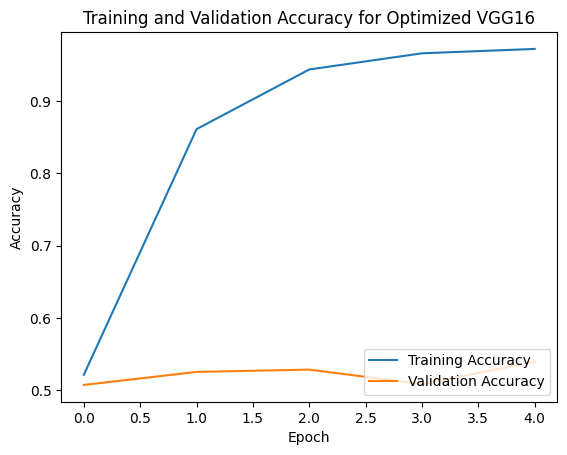

In [21]:
# Optimized VGG16 Model for Debugging
!pip install patool==1.12
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import drive
import patoolib

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory containing the dataset
data_dir = '/content/extracted_images/leapGestRecog'

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    validation_split=0.3,  # Reserve 30% for validation
    horizontal_flip=True,  # Randomly flip images horizontally
    rescale=1.0/255.0      # Scale pixel values to [0, 1]
)

# Validation data generator without augmentation (only rescaling)
validation_datagen = ImageDataGenerator(
    validation_split=0.3,
    rescale=1.0/255.0
)

# Load the training dataset with data augmentation
train_dataset = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),  # Correct input size for VGG16
    batch_size=16,  # Use smaller batch size for testing
    class_mode='categorical',
    subset='training',
    seed=123
)

# Load the validation dataset without augmentation
validation_dataset = validation_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),  # Correct input size for VGG16
    batch_size=16,  # Use smaller batch size for testing
    class_mode='categorical',
    subset='validation',
    seed=123
)

# Display class names to verify labels
class_names = list(train_dataset.class_indices.keys())
num_classes = len(class_names)
print(f"Class Names: {class_names}")
print(f"Number of classes: {num_classes}")

# Check the shape of the datasets
for images, labels in train_dataset:
    print(f"Train Dataset - Image batch shape: {images.shape}")
    print(f"Train Dataset - Label batch shape: {labels.shape}")
    break

for images, labels in validation_dataset:
    print(f"Validation Dataset - Image batch shape: {images.shape}")
    print(f"Validation Dataset - Label batch shape: {labels.shape}")
    break

# Load the pre-trained VGG16 model with a specific input shape
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set the base model layers to be trainable for fine-tuning (optional)
base_model.trainable = False

# Build the model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Explicitly define input shape
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling instead of Flatten
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model using Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify all shapes
model.summary()

# Train the VGG16 model with EarlyStopping to monitor for overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Set a limited number of epochs for testing
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_dataset, verbose=2)
print(f"Validation accuracy: {val_acc:.4f}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy for Optimized VGG16')
plt.show()
